In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import glob
import random as r
import skimage.io as io
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, UpSampling2D,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        
        if label == 1:
            img[img != 0 ] = 1 # tam tümör
        if label == 2:
            img[img != 1 ] = 0 # nekroz
        if label == 3:
            img[img == 2 ] = 0 # ödemsiz tümör
            img[img != 0 ] = 1
        if label == 4:
            img[img != 4 ] = 0 # genişleyen tümör
            img[img == 4 ] = 1
         
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!

def train_array(path,end):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        img = (img-img.mean())/ img.std()
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32)

In [3]:
flair = train_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*flair.nii.gz')
t2 = train_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*t2.nii.gz')
seg = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 1)

In [13]:
flair = train_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*flair.nii.gz')
t2 = train_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*t2.nii.gz')

MemoryError: Unable to allocate 68.1 MiB for an array with shape (155, 240, 240) and data type float64

In [4]:
x_train = np.concatenate((flair, t2), axis=1) #axis: kacinci index birlestirilecek. Axis 1 olacak cunku zaten tek kanal 1,240,240

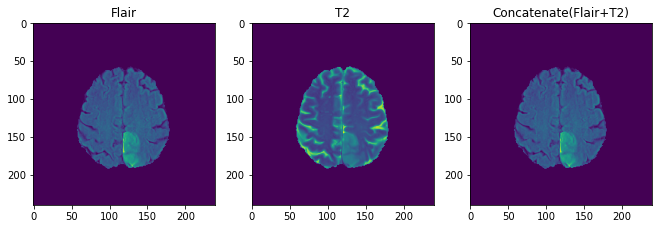

In [5]:
x= 50
fig = plt.figure(figsize=(15,10))

plt.subplot(141)
plt.title('Flair')
plt.imshow(flair[x][0])

plt.subplot(142)
plt.title('T2')
plt.imshow(t2[x][0])

plt.subplot(143)
plt.title('Concatenate(Flair+T2)')
plt.imshow(x_train[x][0])

In [5]:
K.set_image_data_format('channels_first') # (240,240,1) => (1,240,240) yani katman sayisi ilk

def dice_coef(y_true, y_pred): #[piksel farki] https://i.stack.imgur.com/OsH4y.png
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
def unet_model():
    inputs = Input((2, 240 , 240)) #sum of the shapes of the flair and t2 
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model    

In [6]:
model = unet_model()

In [ ]:
callback = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='D://modelweight//new.h5', monitor='val_accuracy', restore_best_weights=True)]

history = model.fit(x_train, seg, validation_split=0.2, batch_size = 10, epochs=10, shuffle=True, verbose=1, callbacks=[callback], initial_epoch = 6)

Epoch 7/10
2067/2067 [==============================] - 1362s 659ms/step - loss: 0.3269 - dice_coef: 0.6732 - val_loss: 0.4125 - val_dice_coef: 0.5870
Epoch 8/10
 101/2067 [>.............................] - ETA: 19:51 - loss: 0.1225 - dice_coef: 0.8775

In [101]:
model.save_weights('D://modelweight//final.h5')

In [5]:
model.load_weights('D://modelweight//final.h5')

In [21]:
print(x_train.shape)

(8750, 2, 240, 240)


In [29]:
example = np.expand_dims(x_train[200], axis=0)

In [30]:
pred = model.predict(example)

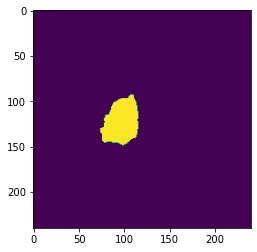

In [31]:
plt.imshow(pred[0][0])

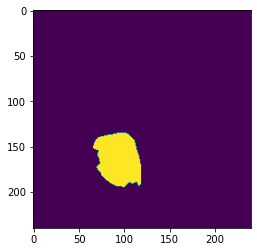

In [12]:
plt.imshow(seg[120][0])

In [1]:
print(flair.shape)

NameError: name 'flair' is not defined

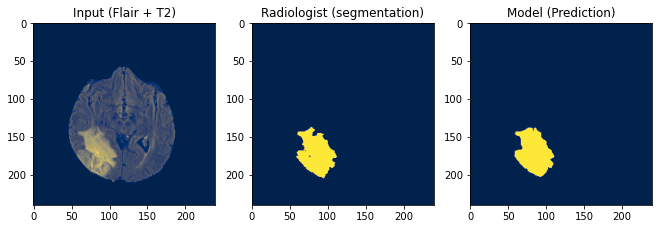

In [14]:
x    = 3500
renk = {0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a    = 4

example = np.expand_dims(x_train[x],axis=0)
pred = model.predict(example)


fig = plt.figure(figsize=(15,10))

plt.subplot(141)
plt.title('Input (Flair + T2)')
plt.imshow(x_train[x][0],cmap = renk[a])

plt.subplot(142)
plt.title('Radiologist (segmentation)')
plt.imshow( seg[x][0],cmap = renk[a])

plt.subplot(143)
plt.title('Model (Prediction)')
plt.imshow( pred[0][0],cmap = renk[a])

In [7]:
t1ce = train_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*t1ce.nii.gz')

MemoryError: Unable to allocate 68.1 MiB for an array with shape (155, 240, 240) and data type float64

In [4]:
seg_necrosis = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 2)


In [4]:
seg_odemsiz = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 3)
seg_enhancing = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 4)

In [3]:
flair = train_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*flair.nii.gz')
t2 = train_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*t2.nii.gz')
seg = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 1)
t1ce = train_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*t1ce.nii.gz')
seg_odemsiz = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 3)
seg_enhancing = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 4)

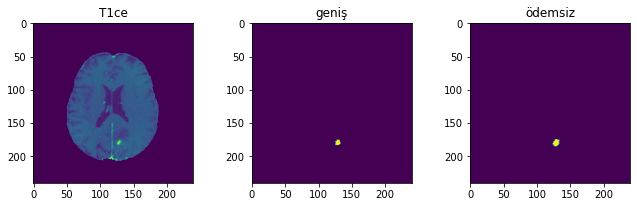

In [19]:
x = 24;
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce[x,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(seg_enhancing[x,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(seg_odemsiz[x,0,:,:])

In [20]:
def tümör_kırpma(mr,seg):
    
    mr = mr[0]
    liste = []
    tmp = seg[0,:,:]
    tmp[tmp>0.2] = 1
    tmp[tmp!= 1] = 0
    index_xy = np.where(tmp==1)
    
    if index_xy[0] != []:
        merkez_y = (max(index_xy[0]) + (min(index_xy[0])) ) / 2
        merkez_x = (max(index_xy[1]) + (min(index_xy[1])) ) / 2
        img_x =  np.zeros((64,64), np.float32)
        img_x[:,:] = mr[int(merkez_y - 64/2):int(merkez_y + 64/2),int(merkez_x - 64/2):int(merkez_x + 64/2) ]
        liste.append(img_x)
        
    return np.array(liste)

def tumortoarray(tumor,segmentasyon):
    
    liste_boş= []

    for i in range(len(segmentasyon)):
        img = tümör_kırpma(tumor[i],segmentasyon[i])
        if len(img.shape) > 2:
            liste_boş.append(img)
            

    return np.array(liste_boş)

odemsiz = tumortoarray(seg_odemsiz,seg_odemsiz)
geniş = tumortoarray(seg_enhancing,seg_odemsiz)
t1ce_kırp = tumortoarray(t1ce,seg_odemsiz)

<ipython-input-20-931def0baac0>:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if index_xy[0] != []:
<ipython-input-20-931def0baac0>:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if index_xy[0] != []:


In [6]:
def tümör_kırpma(mr,seg):
    
    mr = mr[0]
    liste = []
    tmp = seg[0,:,:]
    tmp[tmp>0.2] = 1
    tmp[tmp!= 1] = 0
    index_xy = np.where(tmp==1)
    
    if index_xy[0] != []:
        merkez_y = (max(index_xy[0]) + (min(index_xy[0])) ) / 2
        merkez_x = (max(index_xy[1]) + (min(index_xy[1])) ) / 2
        img_x =  np.zeros((64,64), np.float32)
        img_x[:,:] = mr[int(merkez_y - 64/2):int(merkez_y + 64/2),int(merkez_x - 64/2):int(merkez_x + 64/2) ]
        liste.append(img_x)
        
    return np.array(liste)

In [15]:
liste_ = []

for i in range(len(t1ce)):
    img = tümör_kırpma(t1ce[i],seg_odemsiz[i])
    if len(img.shape) > 2:
        liste_.append(img)

<ipython-input-6-31dd71e8b63d>:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if index_xy[0] != []:
<ipython-input-6-31dd71e8b63d>:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if index_xy[0] != []:


In [10]:
odemsiz = np.array(liste_)

In [12]:
necrosis = np.array(liste_)

In [14]:
enhancing = np.array(liste_)

In [16]:
t1ce = np.array(liste_)

In [20]:
t1ce.shape, odemsiz.shape, enhancing.shape

((12839, 1, 64, 64), (12839, 1, 64, 64), (12839, 1, 64, 64))

In [7]:
K.set_image_data_format('channels_first')

def dice_coef(y_true, y_pred): #[piksel farki] https://i.stack.imgur.com/OsH4y.png
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def unet_model_7():
    
    inputs = Input((1, 64, 64))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
     
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch5)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [27]:
model_odemsiz = unet_model_7()

In [28]:
history = model_odemsiz.fit(t1ce, odemsiz,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

Epoch 1/5
1028/1028 [==============================] - 66s 57ms/step - loss: 0.2631 - dice_coef: 0.7369 - val_loss: 0.2513 - val_dice_coef: 0.7487
Epoch 2/5
1028/1028 [==============================] - 57s 56ms/step - loss: 0.1338 - dice_coef: 0.8662 - val_loss: 0.2043 - val_dice_coef: 0.7958
Epoch 3/5
1028/1028 [==============================] - 57s 56ms/step - loss: 0.0998 - dice_coef: 0.9002 - val_loss: 0.2029 - val_dice_coef: 0.7966
Epoch 4/5
1028/1028 [==============================] - 58s 56ms/step - loss: 0.0853 - dice_coef: 0.9147 - val_loss: 0.1980 - val_dice_coef: 0.8021
Epoch 5/5
1028/1028 [==============================] - 59s 57ms/step - loss: 0.0749 - dice_coef: 0.9251 - val_loss: 0.1967 - val_dice_coef: 0.8032


In [29]:
model_odemsiz.save_weights('D://modelweight//model_odemsiz.h5')

In [30]:
model_enhancing = unet_model_7()

In [31]:
history = model_enhancing.fit(t1ce, enhancing,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

Epoch 1/5
1028/1028 [==============================] - 61s 58ms/step - loss: 0.3464 - dice_coef: 0.6536 - val_loss: 0.3202 - val_dice_coef: 0.6793
Epoch 2/5
1028/1028 [==============================] - 60s 59ms/step - loss: 0.1615 - dice_coef: 0.8385 - val_loss: 0.3025 - val_dice_coef: 0.6970
Epoch 3/5
1028/1028 [==============================] - 61s 59ms/step - loss: 0.1376 - dice_coef: 0.8624 - val_loss: 0.2913 - val_dice_coef: 0.7083
Epoch 4/5
1028/1028 [==============================] - 62s 60ms/step - loss: 0.1244 - dice_coef: 0.8756 - val_loss: 0.2925 - val_dice_coef: 0.7070
Epoch 5/5
1028/1028 [==============================] - 64s 62ms/step - loss: 0.1132 - dice_coef: 0.8868 - val_loss: 0.2855 - val_dice_coef: 0.7140


In [32]:
model_enhancing.save_weights('D://modelweight//model_enhancing.h5')

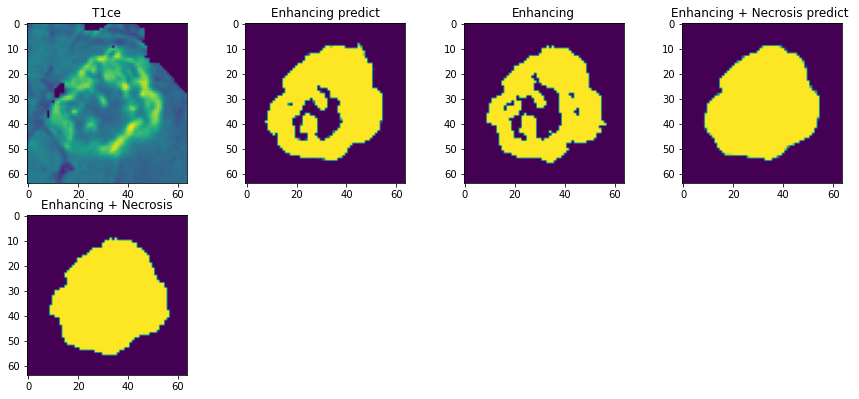

In [37]:
x = 350

plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce[x,0,:,:])


pred_enhancing = model_enhancing.predict(t1ce[x:x+1,:,:,:])
plt.subplot(3,4,2)
plt.title('Enhancing predict')
plt.imshow(pred_enhancing[0,0,:,:] )

plt.subplot(3,4,3)
plt.title('Enhancing')
plt.imshow(enhancing[x,0,:,:])

pred_odemsiz = model_odemsiz.predict(t1ce[x:x+1,:,:,:])
plt.subplot(3,4,4)
plt.title('Enhancing + Necrosis predict ')
plt.imshow(pred_odemsiz[0,0,:,:] )


plt.subplot(3,4,5)
plt.title('Enhancing + Necrosis')
plt.imshow(odemsiz[x,0,:,:])

In [8]:
def tümör_kırp(x, pred, size): 
    crop_x = []
    list_xy = []
    p_tmp = pred[0,:,:]
    p_tmp[p_tmp>0.2] = 1    
    p_tmp[p_tmp !=1] = 0
    index_xy = np.where(p_tmp==1)  

    if index_xy[0].shape[0] == 0: 
        return [],[]
        
    center_x = (max(index_xy[0]) + min(index_xy[0])) / 2 
    center_y = (max(index_xy[1]) + min(index_xy[1])) / 2 
    
    if center_x >= 176:
            center_x = center_x-8
        
    length = max(index_xy[0]) - min(index_xy[0])
    width = max(index_xy[1]) - min(index_xy[1])
        
    if width <= 64 and length <= 64:  #64x64
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y - size/2)))
            
    if width > 64 and length <= 64:  #64x128
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y)))
            
    if width <= 64 and length > 64:  #128x64       
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y - size/2)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y - size/2)))
            
    if width > 64 and length > 64:  #128x128
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y)))
        
    
        
    return np.array(crop_x) , list_xy

In [199]:
sayı = 15300

görüntü1, kordinat1 = tümör_kırp(t1ce[sayı,:,:,:],seg[sayı,:,:,:],64)
görüntü2, kordinat2 = tümör_kırp(seg_enhancing[sayı,:,:,:],seg[sayı,:,:,:],64)
görüntü3, kordinat3 = tümör_kırp(seg_odemsiz[sayı,:,:,:],seg[sayı,:,:,:],64)

t1ce.shape


(25830, 1, 240, 240)

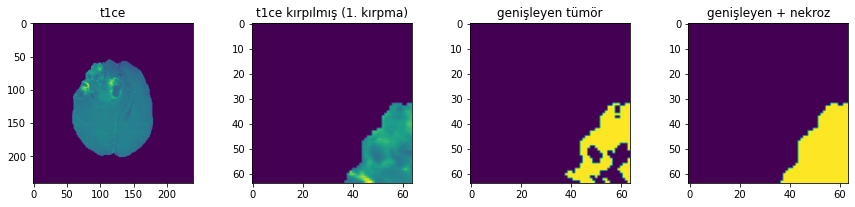

In [200]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('t1ce')
plt.imshow(t1ce[sayı,0,:,:])

plt.subplot(3,4,2)
plt.title('t1ce kırpılmış (1. kırpma)')
plt.imshow(görüntü1[0,0,:,:])

plt.subplot(3,4,3)
plt.title('genişleyen tümör')
plt.imshow(görüntü2[0,0,:,:])

plt.subplot(3,4,4)
plt.title('genişleyen + nekroz')
plt.imshow(görüntü3[0,0,:,:])

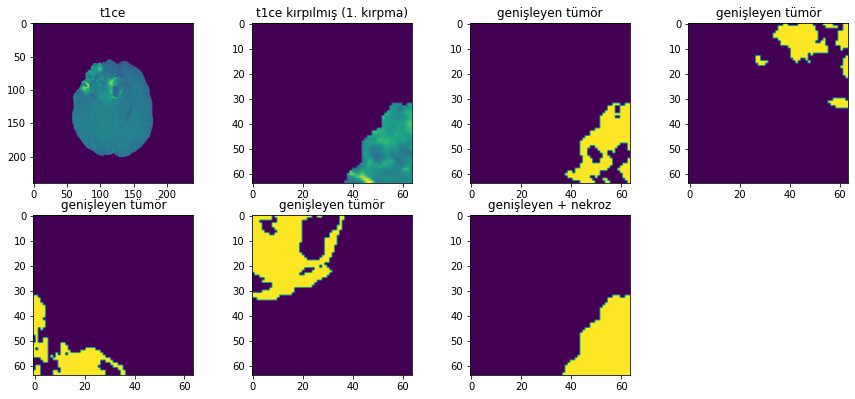

In [201]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('t1ce')
plt.imshow(t1ce[sayı,0,:,:])

plt.subplot(3,4,2)
plt.title('t1ce kırpılmış (1. kırpma)')
plt.imshow(görüntü1[0,0,:,:])

plt.subplot(3,4,3)
plt.title('genişleyen tümör')
plt.imshow(görüntü2[0,0,:,:])

plt.subplot(3,4,4)
plt.title('genişleyen tümör')
plt.imshow(görüntü2[1,0,:,:])

plt.subplot(3,4,5)
plt.title('genişleyen tümör')
plt.imshow(görüntü2[2,0,:,:])

plt.subplot(3,4,6)
plt.title('genişleyen tümör')
plt.imshow(görüntü2[3,0,:,:])

plt.subplot(3,4,7)
plt.title('genişleyen + nekroz')
plt.imshow(görüntü3[0,0,:,:])

In [9]:
def tumor2array(tumor,segmentasyon):

    liste = []

    for i in range(len(tumor)):
        crop , kordinat = tümör_kırp(tumor[i,:,:,:],segmentasyon[i,:,:,:],64)
    
        if crop == []:
            pass
        elif crop.shape[0] ==1:
            liste.append(crop[0])
        
        elif crop.shape[0] ==2:
        
           liste.append(crop[0])
           liste.append(crop[1])
        
        elif crop.shape[0] ==4:
        
            liste.append(crop[0])
            liste.append(crop[1])
            liste.append(crop[2])
            liste.append(crop[3]) 
    
    return np.array(liste)

In [10]:
t1ce_array = tumor2array(t1ce,seg)
enhancing_array = tumor2array(seg_enhancing,seg)
odemsiz_array = tumor2array(seg_odemsiz,seg)

<ipython-input-9-1820e48c545c>:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if crop == []:


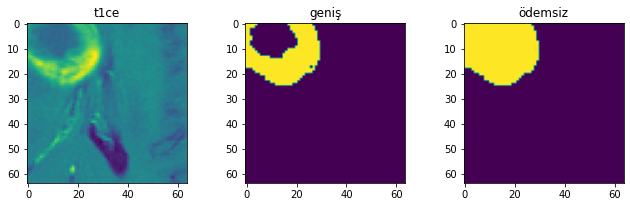

In [209]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('t1ce')
plt.imshow(t1ce_array[15300,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(enhancing_array[15300,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(odemsiz_array[15300,0,:,:])

In [11]:
model_odemsiz = unet_model_7()

In [213]:
history = model_odemsiz.fit(t1ce_array, odemsiz_array,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

Epoch 1/5
2471/2471 [==============================] - 149s 57ms/step - loss: 0.3996 - dice_coef: 0.6004 - val_loss: 0.4374 - val_dice_coef: 0.5623
Epoch 2/5
2471/2471 [==============================] - 141s 57ms/step - loss: 0.2043 - dice_coef: 0.7957 - val_loss: 0.4063 - val_dice_coef: 0.5934
Epoch 3/5
2471/2471 [==============================] - 144s 58ms/step - loss: 0.1728 - dice_coef: 0.8272 - val_loss: 0.4135 - val_dice_coef: 0.5863
Epoch 4/5
2471/2471 [==============================] - 150s 61ms/step - loss: 0.1480 - dice_coef: 0.8520 - val_loss: 0.4043 - val_dice_coef: 0.5954
Epoch 5/5
2471/2471 [==============================] - 159s 64ms/step - loss: 0.1399 - dice_coef: 0.8601 - val_loss: 0.3819 - val_dice_coef: 0.6181


In [215]:
model_odemsiz.save_weights('D://modelweight//model_odemsiz_array.h5')

In [13]:
model_enhancing = unet_model_7()

In [11]:
history = model_enhancing.fit(t1ce_array, enhancing_array,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

Epoch 1/5
2471/2471 [==============================] - 148s 57ms/step - loss: 0.4744 - dice_coef: 0.5256 - val_loss: 0.5063 - val_dice_coef: 0.4934
Epoch 2/5
2471/2471 [==============================] - 140s 57ms/step - loss: 0.1969 - dice_coef: 0.8031 - val_loss: 0.4930 - val_dice_coef: 0.5068
Epoch 3/5
2471/2471 [==============================] - 143s 58ms/step - loss: 0.1654 - dice_coef: 0.8346 - val_loss: 0.4683 - val_dice_coef: 0.5315
Epoch 4/5
2471/2471 [==============================] - 147s 60ms/step - loss: 0.1569 - dice_coef: 0.8431 - val_loss: 0.4894 - val_dice_coef: 0.5104
Epoch 5/5
2471/2471 [==============================] - 153s 62ms/step - loss: 0.1533 - dice_coef: 0.8467 - val_loss: 0.4435 - val_dice_coef: 0.5563


In [12]:
model_enhancing.save_weights('D://modelweight//model_enhancing_array.h5')

In [14]:
model_enhancing.load_weights('D://modelweight//model_enhancing_array.h5')
model_odemsiz.load_weights('D://modelweight//model_odemsiz_array.h5')
model.load_weights('D://modelweight//final.h5')

In [81]:
x = 15300
görüntü , koordinat = tümör_kırp(t1ce[x,:,:,:],seg[x,:,:,:],64)

In [82]:
pred_odemsiz = model_odemsiz.predict(görüntü)
pred_enhancing = model_enhancing.predict(görüntü)
pred_tam = model.predict(x_train[x:15301,:,:,:])

In [83]:
pred_tam[pred_tam > 0.2] = 2
pred_tam[pred_tam != 2 ] = 0

pred_odemsiz[pred_odemsiz > 0.2] = 1
pred_odemsiz[pred_odemsiz != 1 ] = 0

pred_enhancing[pred_enhancing > 0.2] = 4
pred_enhancing[pred_enhancing != 4 ] = 0

In [84]:
def üstüne_ekle(pred_tam, pred_odemsiz , pred_enhancing , koordinat):  
    
    total = np.zeros((1,240,240),np.float32)  
    total[:,:,:] = pred_tam[:,:,:]
    
    for i in range(pred_odemsiz.shape[0]):
        for j in range(64):
            for k in range(64):
                
                if pred_odemsiz[i,0,j,k] != 0 and pred_tam[0,koordinat[i][0]+j,koordinat[i][1]+k] !=0:
                    total[0,koordinat[i][0]+j,koordinat[i][1]+k] = pred_odemsiz[i,0,j,k]
                    
                if pred_enhancing[i,0,j,k] != 0 and pred_tam[0,koordinat[i][0]+j,koordinat[i][1]+k] !=0:
                    total[0,koordinat[i][0]+j,koordinat[i][1]+k] = pred_enhancing[i,0,j,k]
                
    return total

In [85]:
deneme = üstüne_ekle(pred_tam[0,:,:,:], pred_odemsiz, pred_enhancing, koordinat)

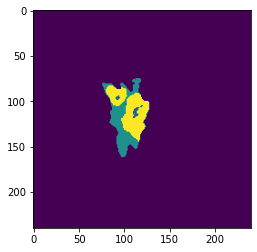

In [86]:
plt.imshow(deneme[0])

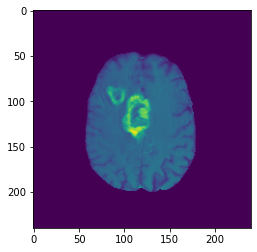

In [87]:
plt.imshow(t1ce[15300,0,:,:])

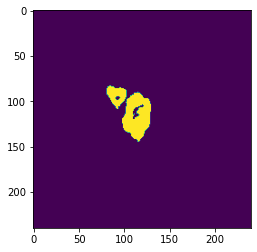

In [88]:
plt.imshow(seg_enhancing[15300,0,:,:])

ValueError: in user code:

    c:\users\fatih\anaconda3\envs\fatih\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    c:\users\fatih\anaconda3\envs\fatih\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\fatih\anaconda3\envs\fatih\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\fatih\anaconda3\envs\fatih\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\fatih\anaconda3\envs\fatih\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\fatih\anaconda3\envs\fatih\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    c:\users\fatih\anaconda3\envs\fatih\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    c:\users\fatih\anaconda3\envs\fatih\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\users\fatih\anaconda3\envs\fatih\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 2, 240, 240), found shape=(None, 1, 64, 64)


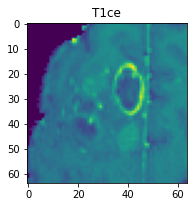

In [21]:
x = 235

plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce_kırp[x,0,:,:])


pred_geniş = model.predict(t1ce_kırp[x:x+1,:,:,:])
plt.subplot(3,4,2)
plt.title('Genişleyen tümör tahmin')
plt.imshow(pred_geniş[0,0,:,:] )

plt.subplot(3,4,3)
plt.title('Genişleyen tümör')
plt.imshow(geniş[x,0,:,:])

pred_ödemsiz = model.predict(t1ce_kırp[x:x+1,:,:,:])
plt.subplot(3,4,4)
plt.title('Genişleyen + Nekroz tahmin ')
plt.imshow(pred_ödemsiz[0,0,:,:] )


plt.subplot(3,4,5)
plt.title('Genişleyen + Nekroz')
plt.imshow(ödemsiz[x,0,:,:])

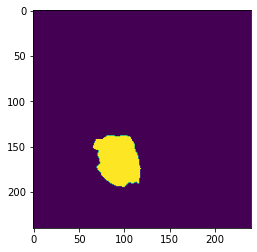

In [9]:
tmp = seg_odemsiz[120,0,:,:]
plt.imshow(tmp)

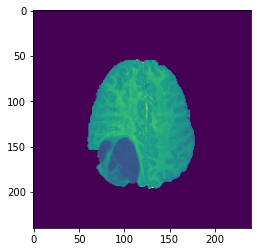

In [10]:
x = t1ce[120,0,:,:]
plt.imshow(x)

In [11]:
def tumor_clipping(mr,seg):
    mr = mr[0]
    list = []
    tmp = seg[0,:,:]
    
    tmp[tmp>0.2] = 1
    tmp[tmp!=1] = 0
    index_xy = np.where(tmp==1)
    
    if index_xy[0] != []:
        center_y = (max(index_xy[0]) + (min(index_xy[0]))) / 2
        center_x = (max(index_xy[1]) + (min(index_xy[1]))) / 2
        img_x = np.zeros((64,64), np.float32)
        img_x[:,:] = mr[int(center_y - 64/2):int(center_y + 64/2),int(center_x - 64/2):int(center_x + 64/2)]
        list.append(img_x)
    return np.array(list)

In [12]:
t1ce_def = tumor_clipping(t1ce[120],seg_odemsiz[120])
odemsiz_def = tumor_clipping(seg_odemsiz[120],seg_odemsiz[120])

<ipython-input-11-91cdab79729b>:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if index_xy[0] != []:


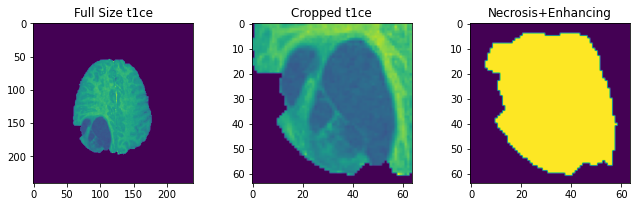

In [15]:
fig = plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('Full Size t1ce')
plt.imshow(t1ce[120,0,:,:])

plt.subplot(3,4,2)
plt.title('Cropped t1ce')
plt.imshow(t1ce_def[0])

plt.subplot(3,4,3)
plt.title('Necrosis+Enhancing')
plt.imshow(odemsiz_def[0])